In [12]:
import numpy as np 
import pandas as pd 
import os
import math

import cv2
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab.patches import cv2_imshow

import tensorflow.keras as keras
from tensorflow.keras.applications import EfficientNetB1, EfficientNetB0
from tensorflow.keras import Sequential
from keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

from random import randint


# Load models

In [13]:
def load_mobilenetv2_224_075_detector(path):
    input_tensor = Input(shape=(224, 224, 3))
    output_tensor = MobileNetV2(weights=None, include_top=False, input_tensor=input_tensor, alpha=0.75).output
    output_tensor = ZeroPadding2D()(output_tensor)
    output_tensor = Conv2D(kernel_size=(3, 3), filters=5)(output_tensor)

    model = Model(inputs=input_tensor, outputs=output_tensor)
    model.load_weights(path)
    
    return model



In [14]:
path = '/content/drive/Othercomputers/My Laptop/Enhance IT docs/Computer Vision (CNN)/project 6( mask_detection)/facedetection-mobilenetv2-size224-alpha0.75.h5'
Face = load_mobilenetv2_224_075_detector(path)

In [15]:
EfficientNetB1 = EfficientNetB1(
    include_top=False,
    weights=None,
    input_tensor=None,
    input_shape=(64,64,3),
    pooling='avg',
    classes=1000,
    classifier_activation="softmax"
)

Mask = Sequential([
    Input(shape=(64,64,3)),
    #Model layers
    EfficientNetB1,
    Flatten(),
    Dense(1032, activation="relu"),
    Dropout(0.2),
    Dense(516, activation="relu"),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.4),
    Dense(2, activation="softmax")
])

# Mask = Sequential([
#     Input(shape=(64,64,3)),
#     #Model layers
#     EfficientNetB0,
#     Flatten(),
#     #Dense(1032, activation="relu"),
#     #Dropout(0.2),
#     Dense(516, activation="relu"),
#     Dropout(0.4),
#     Dense(64, activation="relu"),
#     Dropout(0.5),
#     Dense(2, activation="softmax")
# ])

path = '/content/drive/Othercomputers/My Laptop/Enhance IT docs/Computer Vision (CNN)/project 6( mask_detection)/Mask_weights.h5'
Mask.load_weights(path)

## Functions

In [16]:
def sigmoid(x):
    return 1 / (np.exp(-x) + 1)


In [17]:
def rectangles_common(a,b,threshold, length = True):
  if length:
    a = (a[0],a[1],a[0]+a[2],a[1]+a[3])
    b = (b[0],b[1],b[0]+b[2],b[1]+b[3])
  if b[0] <= a[0] <= b[2] or b[0] <= a[2] <= b[2] or a[0] <= b[0] <= a[2] or a[0] <= b[2] <= a[2]:
    if b[1] <= a[1] <= b[3] or b[1] <= a[3] <= b[3] or a[1] <= b[1] <= a[3] or a[1] <= b[3] <= a[3]:
      p1 = sorted([a[0],a[2],b[0],b[2]])
      p2 = sorted([a[1],a[3],b[1],b[3]])
      p = (p1[2]-p1[1])*(p2[2]-p2[1])
      a = (a[2]-a[0])*(a[3]-a[1])
      b = (b[2]-b[0])*(b[3]-b[1])
      return max(p/a,p/b) > threshold
  return False

In [18]:
def overlay_transparent(background, overlay, x, y):

    background_width = background.shape[1]
    background_height = background.shape[0]

    if x >= background_width or y >= background_height:
        return background

    h, w = overlay.shape[0], overlay.shape[1]

    if x + w > background_width:
        w = background_width - x
        overlay = overlay[:, :w]

    if y + h > background_height:
        h = background_height - y
        overlay = overlay[:h]

    if overlay.shape[2] < 4:
        overlay = np.concatenate(
            [
                overlay,
                np.ones((overlay.shape[0], overlay.shape[1], 1), dtype = overlay.dtype) * 255
            ],
            axis = 2,
        )

    overlay_image = overlay[..., :3]
    mask = overlay[..., 3:] / 255.0

    background[y:y+h, x:x+w] = (1.0 - mask) * background[y:y+h, x:x+w] + mask * overlay_image

    return background

In [19]:
def print_img_squares(img_path, threshold = 0.5, threshold_overlap = 0.7,  alpha_x = 1, alpha_y = 1, verbose = 1):
  Ip = Image.open(img_path)
  Ip2 = Ip.resize((224,224))
  IP_arr = np.array(Ip2)[np.newaxis,:,:,:]
  pred = Face.predict(IP_arr)[0]
  l = []
  x_shape = pred.shape[0]
  y_shape = pred.shape[1]

  for i in range(x_shape):
    for j in range(y_shape):
      if sigmoid(pred[i,j,4]) > threshold:
        m = []
        m.append((sigmoid(pred[i,j,0])+i)/x_shape)
        m.append((sigmoid(pred[i,j,1])+j)/y_shape)
        m.append(min(math.exp(pred[i][j][2] / x_shape), x_shape)/x_shape)
        m.append(min(math.exp(pred[i][j][3] / y_shape), y_shape)/y_shape)
        m.append(sigmoid(pred[i,j,4]))
        l.append(m)

  for p in range(len(l)):
    x = l[p]
    x = [x[0]*Ip.size[0], x[1]*Ip.size[1], x[2]*Ip.size[0], x[3]*Ip.size[1], x[4]]
    l[p] = (max(0,x[0]-x[2]*alpha_x/2), max(0,x[1]-x[3]*alpha_y/2), min(x[0]+x[2]*alpha_x/2,Ip.size[0]), min(x[1]+x[3]*alpha_y/2,Ip.size[1]), x[4])

  # Remove overlapping pictures
  l.sort(key=lambda x: x[4])
  lp = []
  for r1 in l:
    for r2 in lp:
      if rectangles_common(r1,r2,threshold_overlap,length = False):
        lp.remove(r2)
    lp.append(r1)
  l = lp
 
  With_Mask = []
  for p in l:
    pic = Ip.crop(p[:4])
    pic = pic.resize((64,64))
    IP_arr = np.array(pic)[np.newaxis,:,:,:]/255
    pred = Mask.predict(IP_arr)[0]
    classes = ['with_mask', 'without_mask']
    With_Mask.append((classes[pred.argmax()],round(pred[pred.argmax()]*100,2)))

  if verbose == 1:
    fig, ax = plt.subplots(1,2,figsize=(20,10))
    ax[0].imshow(Ip)
    ax[1].imshow(Ip)
    for r, m in zip(l, With_Mask):
      rect = patches.Rectangle((r[0], r[1]), r[2]-r[0], r[3]-r[1], linewidth=1,
                            edgecolor='r', facecolor="none")
      ax[1].add_patch(rect)
      ax[1].annotate(str(int(round(r[4],2)*100)) + '%|' + 'face', (r[0], r[1]),
                   color='black', weight='bold', 
                   fontsize=10, ha='left', va='baseline',
                   bbox=dict(boxstyle="square", fc="white"))
      ax[1].annotate(str(m[1]) + '%|' + m[0], (r[0], r[3]),
                   color='black', weight='bold', 
                   fontsize=10,# ha='left', va='baseline',
                   bbox=dict(boxstyle="square", fc="white"))
    plt.show()
  elif verbose == 2:
    background = cv2.imread(path,cv2.IMREAD_UNCHANGED)
    for r, m in zip(l, With_Mask):
      if m[0] == 'with_mask':
        image2 = cv2.imread('/content/drive/Othercomputers/My Laptop/Enhance IT docs/Computer Vision (CNN)/project 6( mask_detection)/ff/Stamps/Mask'+str(randint(1,2))+'.png', 
                            cv2.IMREAD_UNCHANGED)
      else:
        image2 = cv2.imread('/content/drive/Othercomputers/My Laptop/Enhance IT docs/Computer Vision (CNN)/project 6( mask_detection)/ff/Stamps/NoMask'+str(randint(1,2))+'.png',
                            cv2.IMREAD_UNCHANGED)
      x = [int(i) for i in r]
      x = [x[0],x[1],x[2]-x[0],x[3]-x[1]]
      r = min(x[2],x[3])
      if image2.shape[0]>image2.shape[1]:
        image2=cv2.resize(image2, (r*image2.shape[1]//image2.shape[0],r))
      else:
        image2=cv2.resize(image2, (r,r*image2.shape[0]//image2.shape[1]))
      background = overlay_transparent(background, image2, x[0]+(x[2]-image2.shape[1])//2, x[1]+(x[3]-image2.shape[0])//3)
    cv2_imshow(background)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


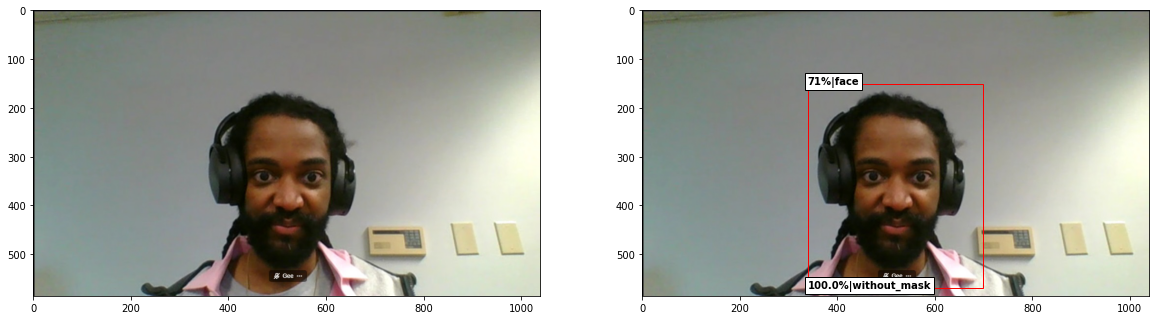

In [20]:

path = '/content/drive/Othercomputers/My Laptop/Enhance IT docs/Computer Vision (CNN)/project 6( mask_detection)/ff/Test pictures/8.jpg'
print_img_squares(path, threshold = 0.1, threshold_overlap=0.7, alpha_x = 1.5, alpha_y = 1.5, verbose=1)

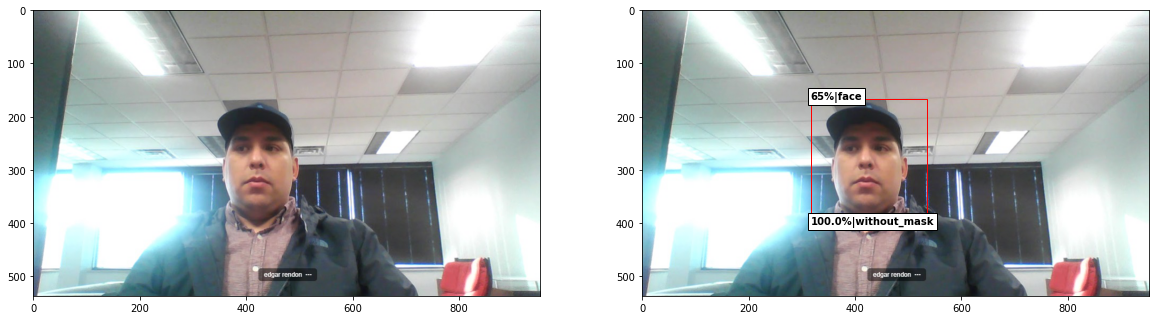

In [21]:
path = '/content/drive/Othercomputers/My Laptop/Enhance IT docs/Computer Vision (CNN)/project 6( mask_detection)/ff/Test pictures/1.jpg'
print_img_squares(path, threshold = 0.1, threshold_overlap=0.7, alpha_x = 1.5, alpha_y = 1.5, verbose=1)

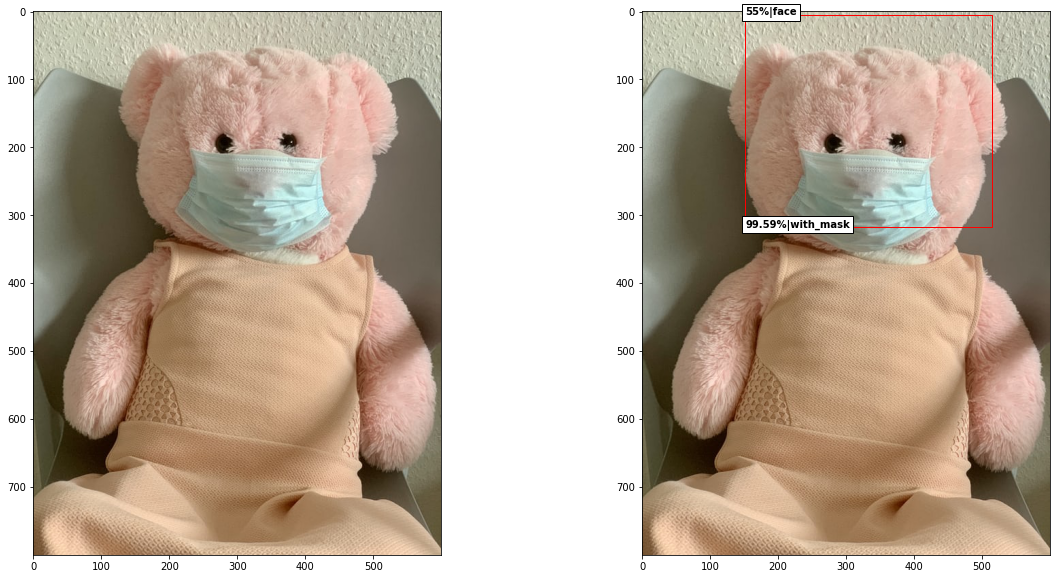

In [22]:
path = '/content/drive/Othercomputers/My Laptop/Enhance IT docs/Computer Vision (CNN)/project 6( mask_detection)/ff/Test pictures/bear.jfif'
print_img_squares(path, threshold = 0.1, threshold_overlap=0.7, alpha_x = 1.5, alpha_y = 1.5, verbose=1)

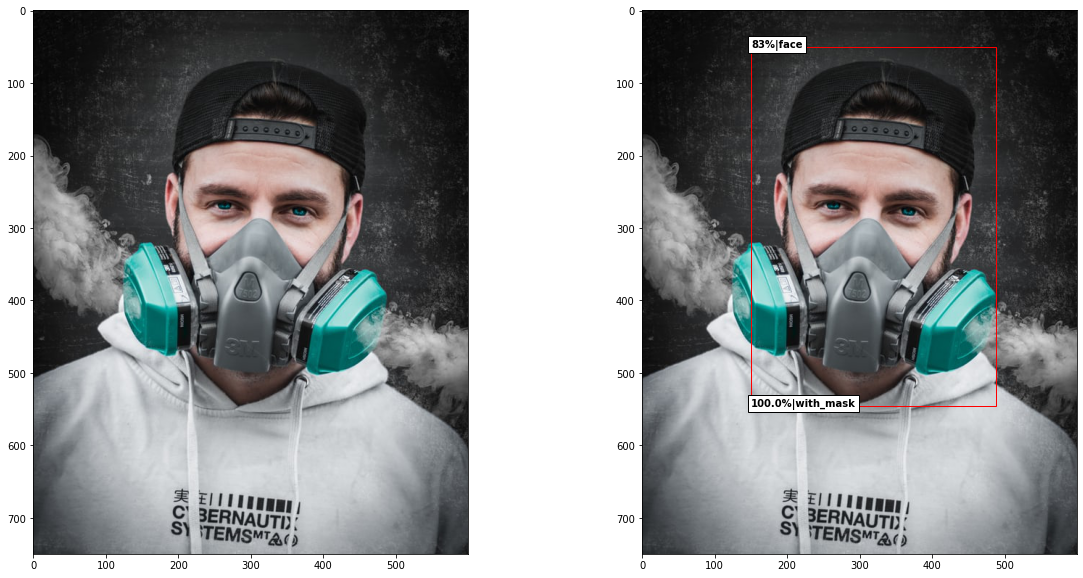

In [23]:
path = '/content/drive/Othercomputers/My Laptop/Enhance IT docs/Computer Vision (CNN)/project 6( mask_detection)/ff/Test pictures/7.jfif'
print_img_squares(path, threshold = 0.1, threshold_overlap=0.7, alpha_x = 1.5, alpha_y = 1.5, verbose=1)

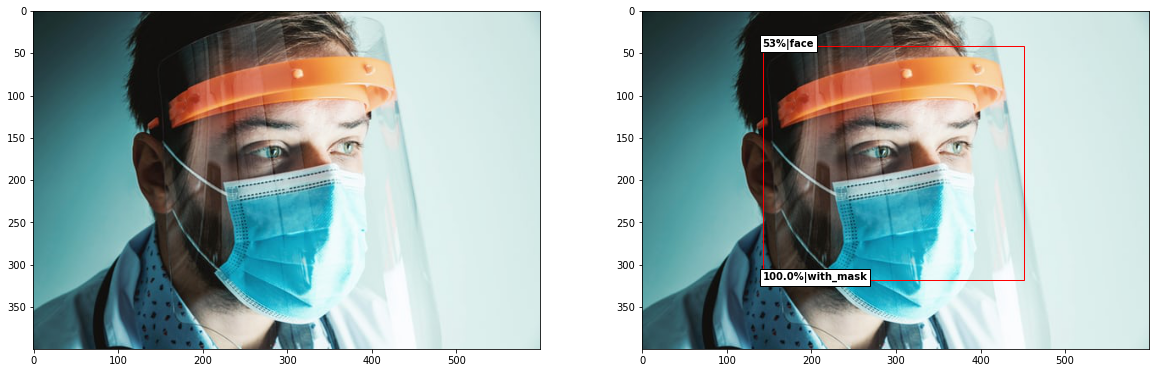

In [24]:
path = '/content/drive/Othercomputers/My Laptop/Enhance IT docs/Computer Vision (CNN)/project 6( mask_detection)/ff/Test pictures/12.jfif'
print_img_squares(path, threshold = 0.1, threshold_overlap=0.7, alpha_x = 1.5, alpha_y = 1.5, verbose=1)

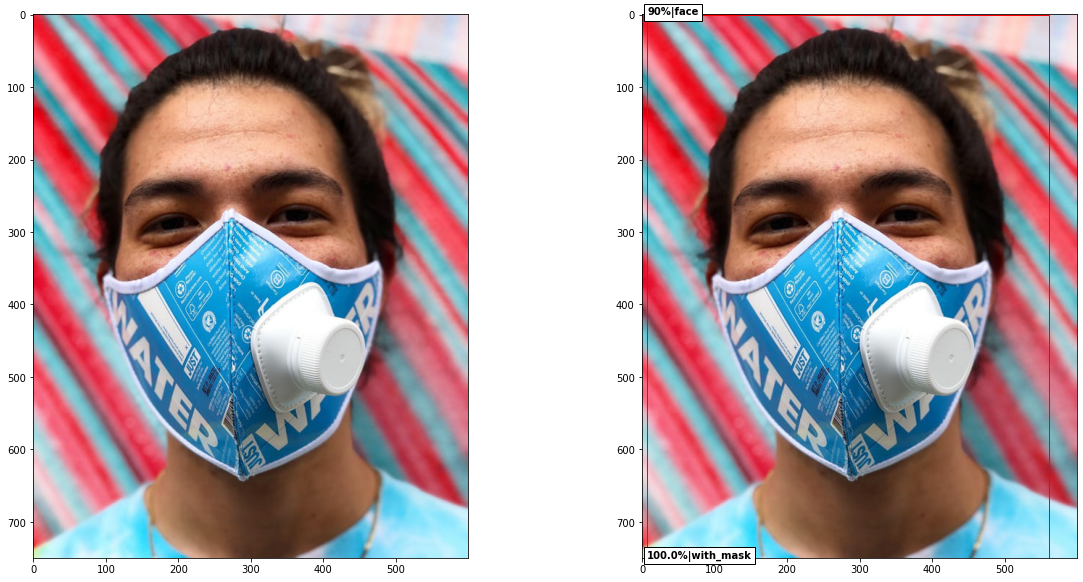

In [25]:
path = '/content/drive/Othercomputers/My Laptop/Enhance IT docs/Computer Vision (CNN)/project 6( mask_detection)/ff/Test pictures/23.jfif'
print_img_squares(path, threshold = 0.1, threshold_overlap=0.7, alpha_x = 1.5, alpha_y = 1.5, verbose=1)

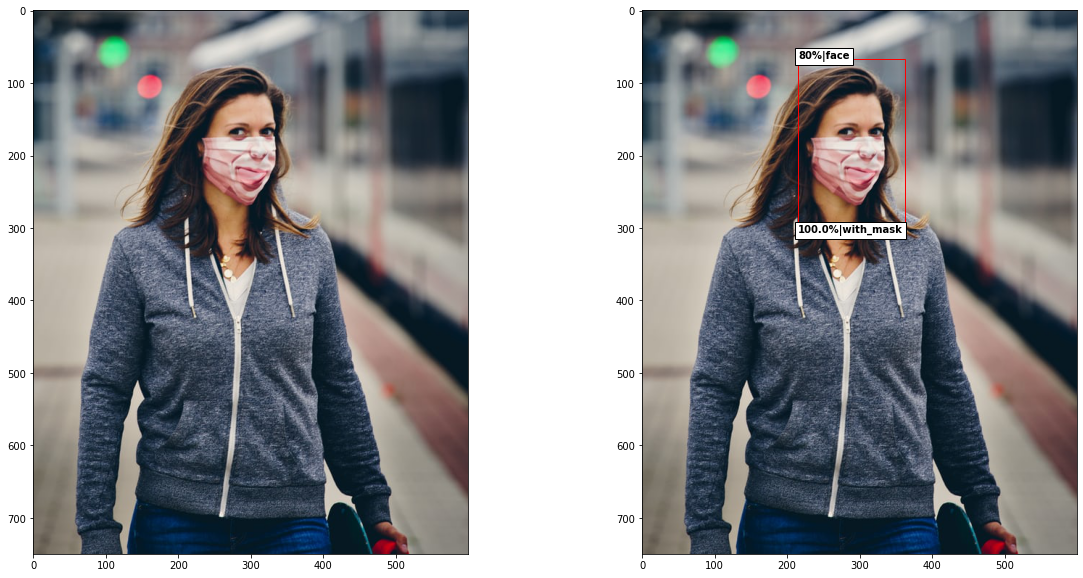

In [26]:
path = '/content/drive/Othercomputers/My Laptop/Enhance IT docs/Computer Vision (CNN)/project 6( mask_detection)/ff/Test pictures/25.jfif'
print_img_squares(path, threshold = 0.1, threshold_overlap=0.7, alpha_x = 1.5, alpha_y = 1.5, verbose=1)

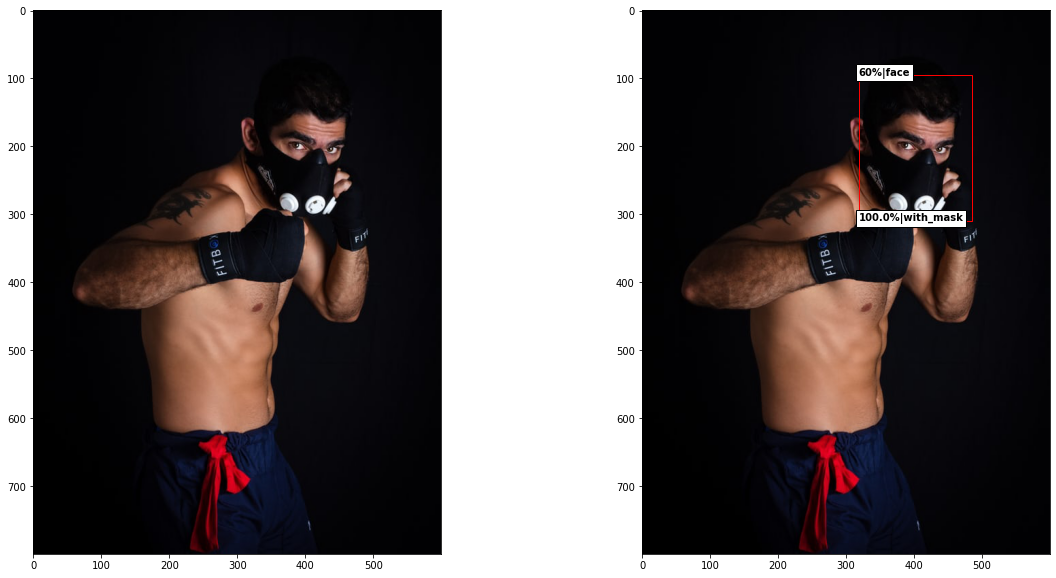

In [27]:
path = '/content/drive/Othercomputers/My Laptop/Enhance IT docs/Computer Vision (CNN)/project 6( mask_detection)/ff/Test pictures/20 (1).png'
print_img_squares(path, threshold = 0.1, threshold_overlap=0.7, alpha_x = 1.5, alpha_y = 1.5, verbose=1)

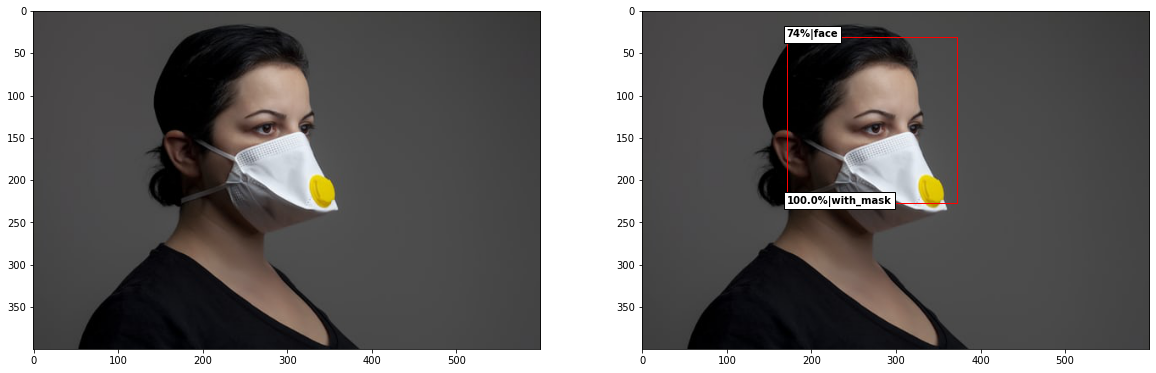

In [28]:
path = '/content/drive/Othercomputers/My Laptop/Enhance IT docs/Computer Vision (CNN)/project 6( mask_detection)/ff/Test pictures/2.jfif'
print_img_squares(path, threshold = 0.1, threshold_overlap=0.7, alpha_x = 1.5, alpha_y = 1.5, verbose=1)

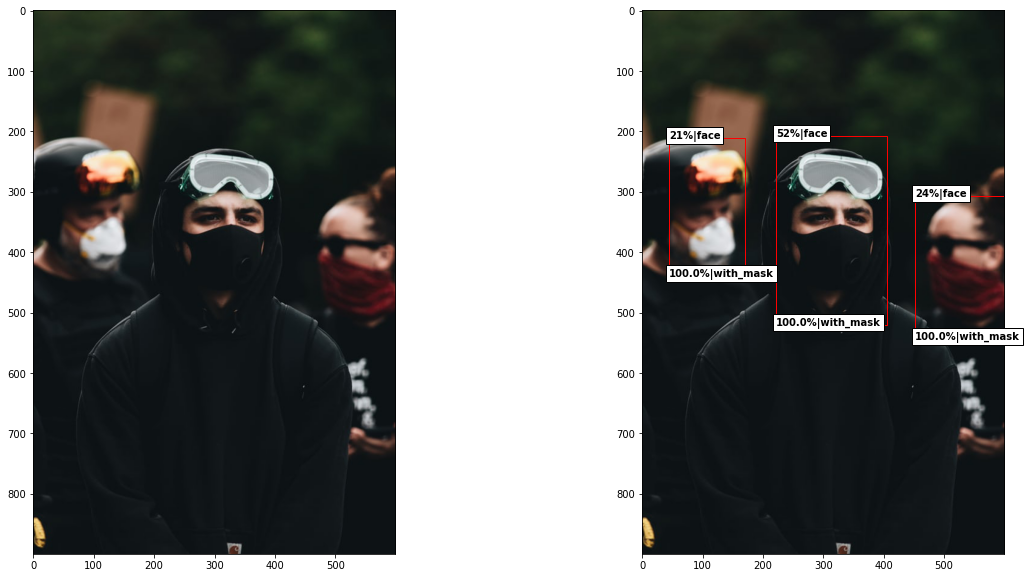

In [31]:
path = '/content/drive/Othercomputers/My Laptop/Enhance IT docs/Computer Vision (CNN)/project 6( mask_detection)/ff/Test pictures/5.jfif'
print_img_squares(path, threshold = 0.1, threshold_overlap=0.7, alpha_x = 1.5, alpha_y = 1.5, verbose=1)

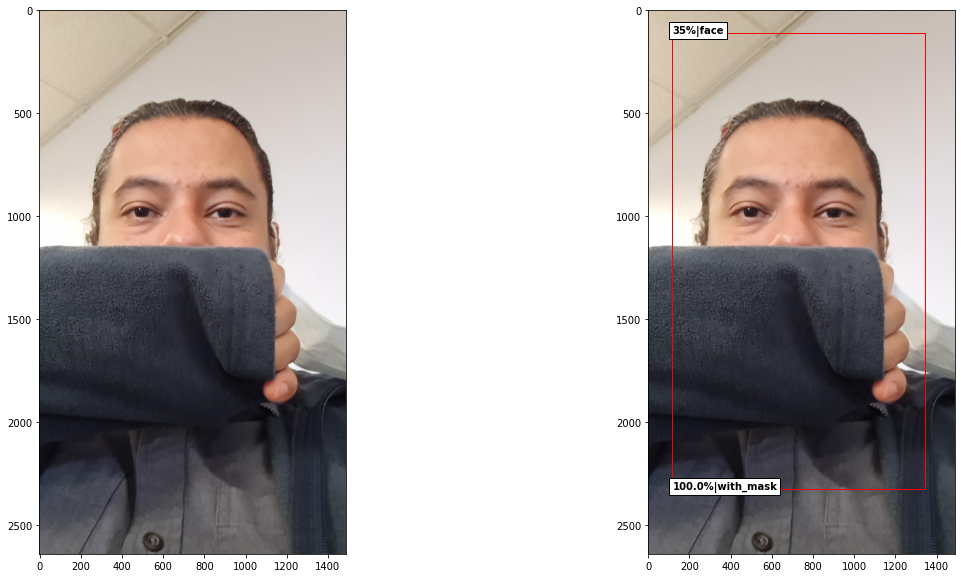

In [33]:
path = '/content/drive/Othercomputers/My Laptop/Enhance IT docs/Computer Vision (CNN)/project 6( mask_detection)/ff/Test pictures/10.jpeg'
print_img_squares(path, threshold = 0.1, threshold_overlap=0.7, alpha_x = 1.5, alpha_y = 1.5, verbose=1)

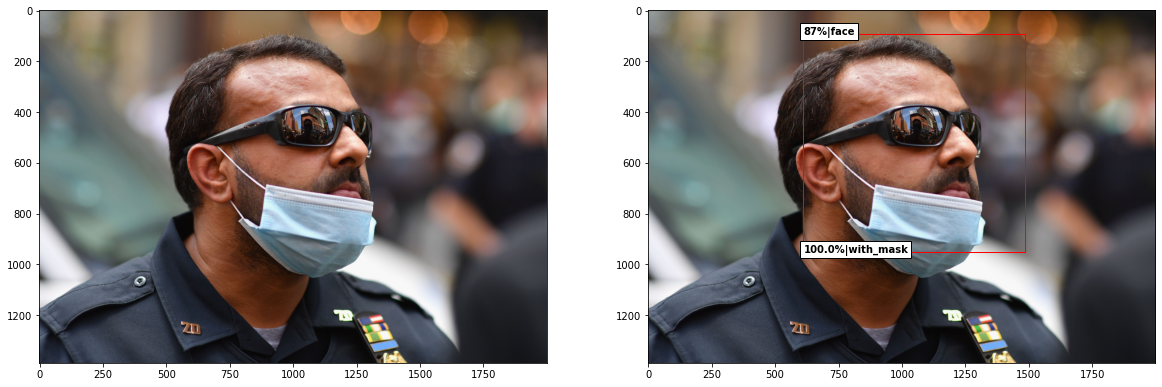

In [34]:
path = '/content/drive/Othercomputers/My Laptop/Enhance IT docs/Computer Vision (CNN)/project 6( mask_detection)/ff/Test pictures/mask.jpg'
print_img_squares(path, threshold = 0.1, threshold_overlap=0.7, alpha_x = 1.5, alpha_y = 1.5, verbose=1)

# DEPLOYMENT

In [62]:
!pip install flask_ngrok

In [106]:
import os
from flask import Flask, request, redirect, url_for, send_from_directory, render_template
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model, model_from_json
from werkzeug.utils import secure_filename
import numpy as np
import tensorflow as tf
from flask_ngrok import run_with_ngrok


ALLOWED_EXTENSIONS = set(['jpg', 'jpeg', 'png'])
IMAGE_SIZE = (75, 75)
UPLOAD_FOLDER = 'uploads'
# converter = tf.lite.TFLiteConverter.from_keras_model('new_model.h5')
# model = converter.convert()

In [107]:
import zipfile
from zipfile import ZipFile

file_name = '/content/drive/Othercomputers/My Laptop/Enhance IT docs/Computer Vision (CNN)/project 6( mask_detection)/templates.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Extracted Successfully')

Extracted Successfully


In [108]:
import zipfile
from zipfile import ZipFile

file_name = '/content/drive/Othercomputers/My Laptop/Enhance IT docs/Computer Vision (CNN)/project 6( mask_detection)/static.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Extracted Successfully')

Extracted Successfully


In [109]:
model =Mask
model.load_weights('/content/templates/Mask_weights.h5')

In [110]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb1 (Functional)  (None, 1280)              6575239   
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1032)              1321992   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1032)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 516)               533028    
_________________________________________________________________
dropout_4 (Dropout)          (None, 516)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

In [111]:
def allowed_file(filename):
    return '.' in filename and \
           filename.rsplit('.', 1)[1] in ALLOWED_EXTENSIONS


In [112]:
def predict(file):
    img  = load_img(file, target_size=IMAGE_SIZE)
    img = img_to_array(img)/255.0
    img = np.expand_dims(img, axis=0)
    probs = model.predict(img)[0]
    output = {'IDC(-):': probs[0], 'IDC(+)': probs[1]}
    return output

In [113]:
app = Flask(__name__)
run_with_ngrok(app)

In [114]:
# @app.route("/")
# def template_test():
#     return render_template('home.html', label='', imagesource='file://null')


# @app.route('/', methods=['GET', 'POST'])
# def upload_file():
#     if request.method == 'POST':
#         file = request.files['file']
        
#         if file and allowed_file(file.filename):
#             filename = secure_filename(file.filename)
#             file_path = os.path.join(app.config['UPLOAD_FOLDER'], filename)
#             file.save(file_path)
#             output = predict(file_path)
#     return render_template("home.html", label=output, imagesource=file_path)


# @app.route('/uploads/<filename>')
# def uploaded_file(filename):
#     return send_from_directory(app.config['UPLOAD_FOLDER'],
#                                filename)

# if __name__ == "__main__":
#     app.run()


In [117]:
@app.route('/', methods=['GET'])
def home():
  return render_template('index.html')

@app.route('/', methods=['GET', "POST"])
def upload_file():
    if request.method == 'POST':
        file = request.files['file']
        
        if file and allowed_file(file.filename):
            filename = secure_filename(file.filename)
            file_path = os.path.join(app.config['UPLOAD_FOLDER'], filename)
            file.save(file_path)
            output = predict(file_path)
    return render_template("home.html", label=output, imagesource=file_path)


def predict():
  if request.method == 'POST':
        file = request.files['file']
        
        if file and allowed_file(file.filename):
            filename = secure_filename(file.filename)
            file_path = os.path.join(app.config['UPLOAD_FOLDER'], filename)
            file.save(file_path)
            prediction =print_img_squares(file_path, threshold = 0.1, threshold_overlap=0.7, alpha_x = 1.5, alpha_y = 1.5, verbose=1)


  # input_values = [str(x) for x in request.form.values()]

  # inp_features = [normalize(input_values)]
  
 
  return render_template('index.html', prediction_text='The topic of the article you entered is: {}'.format(prediction))
 

AssertionError: ignored

In [116]:
app.run()
run_with_ngrok(app)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://016f-35-231-181-11.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [14/Sep/2021 05:06:34] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [14/Sep/2021 05:06:34] "GET /static/css/style.css HTTP/1.1" 200 -
127.0.0.1 - - [14/Sep/2021 05:06:35] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [14/Sep/2021 05:06:35] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [14/Sep/2021 05:06:35] "GET /static/css/style.css HTTP/1.1" 200 -
